1. Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

2. Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

3. Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

4. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [R繹stigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

# Part3
Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.


# Libraries used in part3

In [1]:
import pandas as pd
import seaborn as sns
import folium
import json
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def save_map(map_name, filename):
    map_filename = "maps/"+filename+".html"
    map_name.save(map_filename)

def decodeArc(arcs) :
    x=0;y=0
    conversion = []
    for arc in arcs:
        arc1 = (x + arc[0])*topo_json_data['transform']['scale'][0]+topo_json_data['transform']['translate'][0]
        arc2 = (y + arc[1])*topo_json_data['transform']['scale'][1]+topo_json_data['transform']['translate'][1]
        conversion.append([arc1,arc2])
        x += arc[0]
        y += arc[1]
    return conversion    
    
def reconstruct_shape(arcIdx,shape):
    if(shape == 'MultiPolygon') :
        layer1=[]
        for x in range(len(arcs)):
            layer2 = []
            for y in range(len(arcs[x])):
                layer3 = []
                for z in range(len(arcs[x][y])):
                    if(arcs[x][y][z] <0):
                        layer3=layer3 + decodeArc(arcIndices[-arcs[x][y][z]-1])[::-1]
                    else:   
                        layer3=layer3 + decodeArc(arcIndices[arcs[x][y][z]])
                layer2.append(layer3)
            layer1.append(layer2)
        return layer1
    if(shape == 'Polygon') :
        layer1=[]
        for x in range(len(arcs)):
            layer2 = []
            for y in range(len(arcs[x])):
                if(arcs[x][y] <0):
                    layer2=layer2 + decodeArc(arcIndices[-arcs[x][y]-1])[::-1]
                else :   
                    layer2=layer2 + decodeArc(arcIndices[arcs[x][y]])
            layer1.append(layer2)
        return layer1

# Prerequisite
### Decription of dataset of unemployment rate
We use the dataset with the following attributes:
1. Unemployment rate indicators - Unemployment rate
2. Unemployed indicators        - Registered unemployed
3. Geographical features        - Canton
4. Other attributes             - Nationality
5. Date                         - September, 2017

Based on the definition in [amstat](https://www.amstat.ch/v2/definition.jsp?lang=fr), registered unemployed is the people advertised at regional employment agencies, who are unemployed and immediately available for placement. It does not matter whether they are receiving unemployment benefits or not. This attribute shows the people who don't have a job and intend to get a job as soon as possible, and hence we think it's the best attribute we want to know. 

And because the assignment asks us to choose recent date, we choose the most recent one: September 2017. In our opinion, we only consider the "current" situation in the aspect of unemployment rate. Unemployment rate is not like temperature, it makes no sense to take the average or median of the unemployment rate. For example, if you choose unemployment rate of 6 months (e.g. from April to September) and you find the median of unemployment rate as your reference, and it would be unreasonable because you may calculate the difference between the unemployment rate of foreigners in April and the unemployment rate of Swiss in July as your result.

### Load the dataset of unemployment rate and preprocess

In [3]:
# load the dataset of unemployment rate
unemployment_data = pd.read_excel('data/2017_09_nationality.xlsx')

unemployment_data = unemployment_data.drop(0)
unemployment_data = unemployment_data.drop(['Mois', 'Total'], axis = 1)

unemployment_data=unemployment_data.rename(columns = {'Septembre 2017':'Unemployment_Rate'})


unemployment_data['Unemployment_Rate'] = unemployment_data['Unemployment_Rate'].astype(float)
unemployment_data_foreigner = unemployment_data[unemployment_data['Nationalité'] == 'Etrangers']
unemployment_data_suisse = unemployment_data[unemployment_data['Nationalité'] == 'Suisses']

unemployment_data_foreigner = unemployment_data_foreigner.reset_index(drop=True)
unemployment_data_suisse = unemployment_data_suisse.reset_index(drop=True)


cantonNames = pd.Series(['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR', 'SO', \
                        'BS', 'BL', 'SH', 'AR', 'AI', 'SG', 'GR', 'AG', 'TG', 'TI', 'VD', 'VS', 'NE', 'GE', 'JU'])
unemployment_data_foreigner['Canton_Short'] = cantonNames
unemployment_data_suisse['Canton_Short'] = cantonNames

# show how the current dataframe looks like
unemployment_data_foreigner.head(5)

,Canton,Nationalité,Unemployment_Rate,Canton_Short
0,Zurich,Etrangers,5.3,ZH
1,Berne,Etrangers,5.5,BE
2,Lucerne,Etrangers,3.9,LU
3,Uri,Etrangers,2.1,UR
4,Schwyz,Etrangers,3.4,SZ


### 3.1 Show the difference of unemployment rate for each canton
First we observe that all unemployment rate of foreigners are higher than that of swiss, and hence, it's reasonable to show the result by unemployment_rate_foreigner - nemployment_rate_swiss

In [4]:
# to show that it's true that unemployment rate of foreigners are higher than that of swiss
all(unemployment_data_foreigner['Unemployment_Rate'] > unemployment_data_suisse['Unemployment_Rate'])

True

In [5]:
# calculate the difference of unemployment rate
unemployment_data_foreigner['Diff_With_Swiss'] = unemployment_data_foreigner['Unemployment_Rate'] - \
                                                 unemployment_data_suisse['Unemployment_Rate']
unemployment_data_foreigner.head(4)

,Canton,Nationalité,Unemployment_Rate,Canton_Short,Diff_With_Swiss
0,Zurich,Etrangers,5.3,ZH,2.8
1,Berne,Etrangers,5.5,BE,3.7
2,Lucerne,Etrangers,3.9,LU,2.6
3,Uri,Etrangers,2.1,UR,1.7


### Choropleth map with diverging colormap
Reason: This kind of color map uses two more distinct colors for minimum and maximum values, which improves the drawback of sequential color map. We know sequential colormap only use one color and it's easy to make users confused. Although quantized mapping is very clear in the aspect of coloar, we think too many colors also make it difficult on understanding too.

Furthermore, we set fill_opacity = 1 to make the colors more distinguishable and use interactive map to show the name of canton and unemployment rate

![Sequential Colormap](figure/sequential.png)

![Diverging Colormap](figure/diverging.png)

![Quantized Coloarmap](figure/quantized.png)

[Reference](http://www.kennethmoreland.com/color-maps/ColorMapsExpanded.pdf)

In [6]:
# create the map of Switzerland
suisse_coord = [46.9, 8.3]
map_suisse = folium.Map(location = suisse_coord, 
                         tiles = 'cartodbpositron',
                         zoom_start = 8)

# import the topo json file
topo_path = r'topojson/ch-cantons.topojson.json'
topo_json_data = json.load(open(topo_path))

# add the topo to the map and show the result
folium.TopoJson(open(topo_path), 'objects.cantons').add_to(map_suisse)

map_suisse.choropleth(geo_data    = topo_json_data, 
                  data        = unemployment_data_foreigner,
                  columns     = ['Canton_Short', 'Diff_With_Swiss'],
                  key_on      = 'id',
                  fill_color  = 'GnBu', fill_opacity=1, line_opacity=0.3,
                  topojson    = 'objects.cantons',
                  legend_name = 'Unemployment Rate')

arcIndices = topo_json_data['arcs']
for country in topo_json_data['objects']['cantons']['geometries']:
    shape = country['type']
    arcs = country['arcs']
    gj = folium.GeoJson(
        data={
            'type': shape,
            'coordinates': reconstruct_shape(arcs,shape)
        }, style_function=  lambda x: {'fillColor': 'white',
                                       'opacity': 0,
                                       'color': 'white',
                                       'fillOpacity': 0}
    )
    try:
        gj.add_child(folium.Popup(country['properties']['name'] + ": " + \
                                 '%.2f' % round(unemployment_data_foreigner.set_index('Canton_Short').loc[country['id']][3],1) + '%'))
    except KeyError:
        gj.add_child(folium.Popup((country['properties']['name']+': unkown')))
    gj.add_to(map_suisse)

save_map(map_suisse,"task3")

[map_suisse]('/maps/task3.html')

### 3.2 Adding the differences between age groups and show it by bar plot
To do this, we need another dataset:
### Decription of dataset of number of unemployed by age and nationality
We use the dataset with the following attributes:
1. Unemployed indicators        - Registered unemployed
2. Geographical features        - Canton
3. General characteristic       - Nationality & Age class {15 - 24, 25 - 49, 50 and over}
4. Date                         - September, 2017

In this dataset, it shows the number of unemployed rather than the unemployment rate. However, combined with the dataframe in 3.1, we can easily calculate the unemployment rate in each (nationality, age) class. For example, we can get the unemployment rate of foreigners 6% from the previous dataframe, and based on this current dataframe, we know the number of unemployed foriegners in {15 - 24, 25 - 49, 50 and over} are 100, 200, 300 respectively, so we can find the unemployment rate of foreigners in {15 - 24, 25 - 49, 50 and over} are 1%, 2%, 3% respectively.

### Load the dataset and preprocess

In [7]:
# load the dataset of unemployment rate
unemployment_data_age_nationality = pd.read_excel('data/2017_09_age_nationality.xlsx')


unemployment_data_age_nationality = unemployment_data_age_nationality.drop(0)
unemployment_data_age_nationality = unemployment_data_age_nationality.drop(['Mois', "Classes d'âge 15-24, 25-49, 50 ans et plus"], axis = 1)

unemployment_data_age_nationality = unemployment_data_age_nationality.rename(columns = {'Septembre 2017':'Unemployment_Number'})
unemployment_data_age_nationality = unemployment_data_age_nationality.rename(columns = {'Unnamed: 3':'Age Category'})

unemployment_data_age_nationality = unemployment_data_age_nationality.dropna()

unemployment_data_age_nationality['Unemployment_Number'] = unemployment_data_age_nationality['Unemployment_Number'].astype('int')

# show how the dataset looks like
unemployment_data_age_nationality.head(12)


,Canton,Nationalité,Age Category,Unemployment_Number
1,Zurich,Etrangers,15-24 ans,1015
2,Zurich,Etrangers,25-49 ans,8846
3,Zurich,Etrangers,50 ans et plus,2250
5,Zurich,Suisses,15-24 ans,2405
6,Zurich,Suisses,25-49 ans,8207
7,Zurich,Suisses,50 ans et plus,4502
10,Berne,Etrangers,15-24 ans,597
11,Berne,Etrangers,25-49 ans,3316
12,Berne,Etrangers,50 ans et plus,987
14,Berne,Suisses,15-24 ans,1406


### Calculate the unemployment rate

In [8]:
total_unemployed_number = unemployment_data_age_nationality.groupby(['Canton', 'Nationalité']).sum()
unemployment_rate = unemployment_data.set_index(['Canton', 'Nationalité'])

unemployment_data_age_nationality['Unemployment_Rate'] = \
[element.Unemployment_Number * unemployment_rate.loc[element.Canton, element.Nationalité][0] \
 /total_unemployed_number.loc[element.Canton, element.Nationalité][0] \
 for idx, element in unemployment_data_age_nationality.iterrows()]

unemployment_data_age_nationality.head(12)

,Canton,Nationalité,Age Category,Unemployment_Number,Unemployment_Rate
1,Zurich,Etrangers,15-24 ans,1015,0.444183
2,Zurich,Etrangers,25-49 ans,8846,3.871175
3,Zurich,Etrangers,50 ans et plus,2250,0.984642
5,Zurich,Suisses,15-24 ans,2405,0.397810
6,Zurich,Suisses,25-49 ans,8207,1.357516
7,Zurich,Suisses,50 ans et plus,4502,0.744674
10,Berne,Etrangers,15-24 ans,597,0.670102
11,Berne,Etrangers,25-49 ans,3316,3.722041
12,Berne,Etrangers,50 ans et plus,987,1.107857
14,Berne,Suisses,15-24 ans,1406,0.288970


### Show the result in bar chart

In [9]:
# the function to be used for bar plot
def getData(age_class, nationality):
    condition = (unemployment_data_age_nationality['Age Category'] == age_class) & (unemployment_data_age_nationality['Nationalité'] == nationality)
    return unemployment_data_age_nationality[condition]

def plot_(data, title):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 5)
    ax1 = sns.barplot(x = data.Canton , y = data.Unemployment_Rate, ax = ax, ci = None)
    ax1.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax1.set_title(title)

    return ax1

### age 15 - 24 

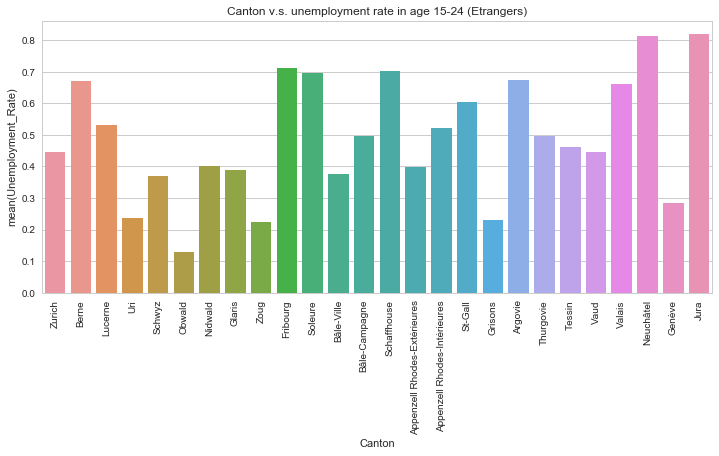

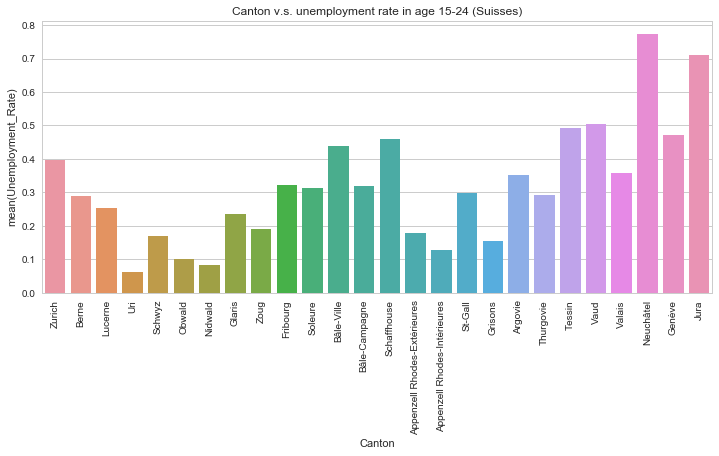

In [10]:
sns.set_style("whitegrid")

data = getData('15-24 ans', 'Etrangers')
plot_(data, 'Canton v.s. unemployment rate in age 15-24 (Etrangers)')

data = getData('15-24 ans', 'Suisses')
plot_(data, 'Canton v.s. unemployment rate in age 15-24 (Suisses)')

### age 25-49

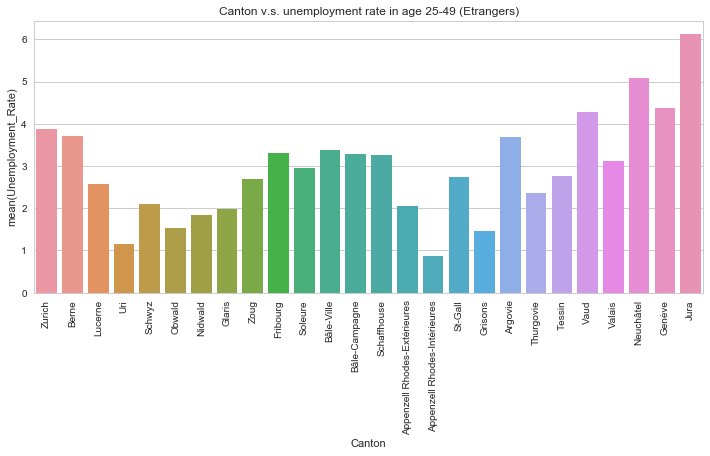

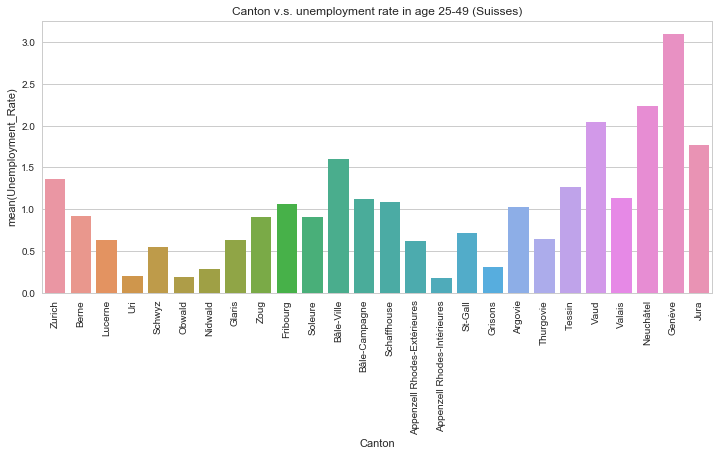

In [11]:
data = getData('25-49 ans', 'Etrangers')
plot_(data, 'Canton v.s. unemployment rate in age 25-49 (Etrangers)')

data = getData('25-49 ans', 'Suisses')
plot_(data, 'Canton v.s. unemployment rate in age 25-49 (Suisses)')

### age 50 up

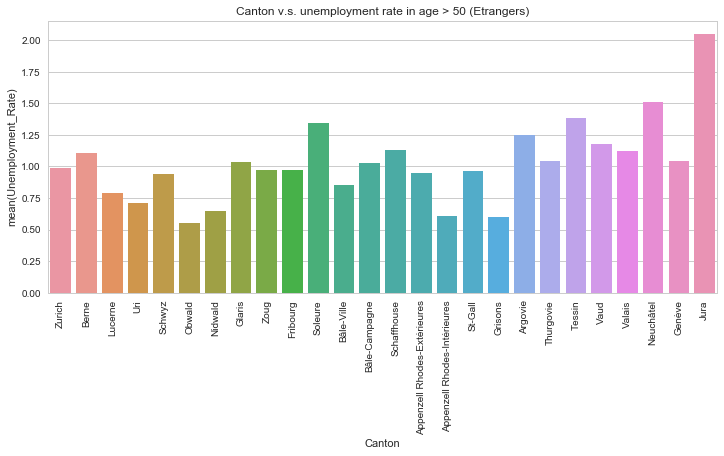

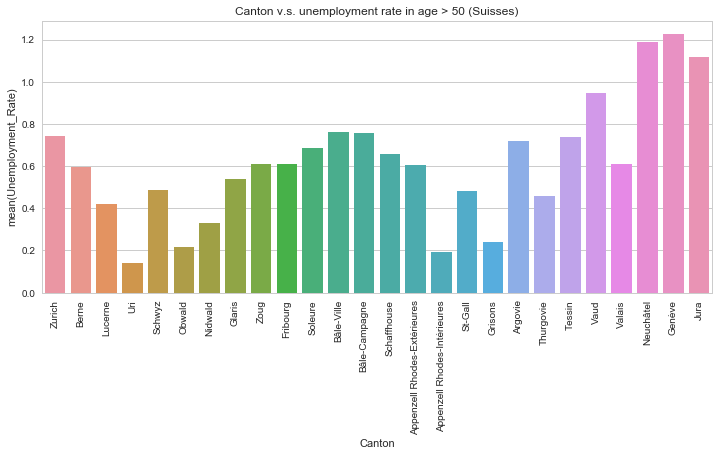

In [12]:
data = getData('50 ans et plus', 'Etrangers')
plot_(data, 'Canton v.s. unemployment rate in age > 50 (Etrangers)')

data = getData('50 ans et plus', 'Suisses')
plot_(data, 'Canton v.s. unemployment rate in age > 50 (Suisses)')